In [6]:
import sys
sys.path.append('..')
import os
import shutil

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

from data import *
from model import Loop
from utils import generate_merlin_wav

from torch.autograd import Variable
from IPython.display import Audio

import phonemizer

import torch
import copy

import pandas as pd

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import evaluate_loss_func_for_notebook as el

In [8]:
os.chdir('/home/ubuntu/loop')
os.getcwd()

'/home/ubuntu/loop'

In [89]:
def map_original_npz_files(workings, data='data/vctk'):
    loader = el.get_loader(data_path=data)

    found = dict()

    for i, npz_file in enumerate(loader.dataset):
        this_file = loader.dataset.npzs[i]
        this_spkr = npz_file[2]
        matched = False

        #print this_file
        #print this_spkr
        for idx in np.nditer(np.where(workings['spkr'] == this_spkr)):
            #print 'iter' + str(idx)
            this_target_txt = workings['txt'][idx, :]
            idx_max = np.max(np.where(this_target_txt != 0))
            this_target_txt = this_target_txt[:idx_max+1]
            
            this_vctk_spkr_id = int(os.path.basename(this_file).split('_')[0][1:])
            this_sentence_id = os.path.basename(this_file).split('_')[1][0:-4]

            if np.array_equal(this_target_txt, npz_file[0].cpu().numpy()):
                #print 'match:' + str(idx)
                matched = True
                found[np.asscalar(idx)] = (i, this_file, this_spkr, this_target_txt, this_vctk_spkr_id, this_sentence_id)
                continue

        if not matched:
            print 'no match: ' + str(i)
            
    return found

In [10]:
def print_phonemes(loader, w):
    d = {b: a for a, b in loader.dataset.dict.iteritems()}
    print [d[x] for x in w] 

In [11]:
def plot_mgc_feature_comparison(feats_a, feats_b, label_a, label_b):
    # plot mgc features
    plt.figure(figsize=(20,20))
    for x in range(60):
        plt.subplot(10, 6, x+1)
        plt.plot(feats_a[:, x])
        plt.plot(feats_b[:, x])
        plt.title('mgc' + str(x))
        if x == 5:
            plt.legend([label_a, label_b])
        if x < 6*9:
            plt.gca().get_xaxis().set_visible(False)
        if not np.mod(x, 6) == 0:
            plt.gca().get_yaxis().set_visible(False)

    plt.suptitle('mgc features', fontsize=14)
    plt.show()

def plot_other_feature_comparison(feats_a, feats_b, label_a, label_b):
    # plot lf0, vuv and bap features
    plt.figure(figsize=(20, 4))

    plt.subplot(1, 3, 1)
    plt.plot(feats_a[:, 60])
    plt.plot(feats_b[:, 60])
    plt.title('vuv')
    plt.grid(True)
    plt.legend([label_a, label_b])

    plt.subplot(1, 3, 2)
    plt.plot(feats_a[:, 61])
    plt.plot(feats_b[:, 61])
    plt.title('lf0')
    plt.grid(True)
    plt.legend([label_a, label_b])

    plt.subplot(1, 3, 3)
    plt.plot(feats_a[:, 62])
    plt.plot(feats_b[:, 62])
    plt.title('bap')
    plt.grid(True)
    plt.legend([label_a, label_b])

    plt.show()

In [12]:
def trim_pred(out, attn):
    tq = np.abs(attn).sum(1)

    for stopi in range(1, tq.shape[0]):
        col_sum = np.abs(attn[:stopi, :]).sum(0).squeeze()

        if type(tq[stopi]) == float:
            if tq[stopi] < 0.5 and col_sum[-1] > 4:
                break
        else:  
            if tq[stopi]< 0.5 and col_sum[-1] > 4:
                break

    out = out[:stopi, :]
    attn = attn[:stopi, :]

    return out, attn

In [13]:
trim_pred(attn=workings['attn'][idx], out=workings['output'][idx,:,:])

NameError: name 'workings' is not defined

In [14]:
def plot_attn(data, labels, dict_file):
    labels_dict = dict_file
    labels_dict = {v: k for k, v in labels_dict.iteritems()}
    labels = [labels_dict[x].decode('latin-1') for x in labels]

    axarr = plt.subplot()
    axarr.imshow(data.T, aspect='auto', origin='lower', interpolation='nearest', cmap=cm.viridis)
    axarr.set_yticks(np.arange(0, len(data.T)))
    axarr.set_yticklabels(labels, rotation=90)

In [15]:
def get_vtck_speaker_info():
    # this is the reference data file that comes as part of VCTK
    speaker_info_file = os.path.join(vctk_raw_folder, 'speaker-info.txt')

   # read file contents
    f = open(speaker_info_file, 'r')
    x = f.readlines()
    f.close()

    # extract column headers
    cols = x[0].lower().split()
    num_cols = len(cols)
    del x[0]
    num_speaker = len(x)

    # parse the data line by line
    d = dict()

    for idx in range(num_speaker):
        this_speaker_id = int(x[idx][:3])
        this_age = int(x[idx][5:7])
        this_gender = x[idx][9]
        residual = x[idx][14:].split()
        this_accent = residual[0]
        this_region = " ".join(residual[1:])

        # add speakers to a dictionary
        d[this_speaker_id] = (this_speaker_id, this_age, this_gender, this_accent, this_region)

    # convert to Pandas datafrae
    speaker_info = pd.DataFrame.from_dict(d, orient='index', columns=cols)
    
    return speaker_info

## Trained Model

In [16]:
loss, workings_best = el.eval_loss(checkpoint='models/vctk/bestmodel.pth')

models/vctk/bestmodel.pth
/home/ubuntu/loop
Namespace(K=10, attention_alignment=0.05, batch_size=64, checkpoint='models/vctk/bestmodel.pth', clip_grad=0.5, data='data/vctk', epochs=90, expName='checkpoints/vctk_noise_2', gpu=0, hidden_size=256, ignore_grad=10000.0, lr=0.0001, max_seq_len=1000, mem_size=20, noise=0, nspk=22, output_size=63, seed=1, seq_len=1000, vocabulary_size=44)


Calculating loss:   0%|          | 0/11 [00:00<?, ?it/s]/home/ubuntu/loop/model.py:110: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  g_t = self.sm(g_t) + self.epsilon
Loss 27.63: 100%|██████████| 11/11 [00:12<00:00,  1.17s/it]


27.4616886486
27.4616891688


In [201]:
#loss, workings_early = el.eval_loss(checkpoint='checkpoints/vctk-rs/bestmodel.pth')
#loss, workings_early = el.eval_loss(checkpoint='checkpoints/vctk-16khz-cmu-no-boundaries-us/bestmodel.pth', data='data/vctk-16khz-cmu-no-boundaries-us')
#loss, workings_early = el.eval_loss(checkpoint='checkpoints/vctk-16khz-cmu-no-boundaries-all/bestmodel.pth', data='data/vctk-16khz-cmu-no-boundaries-all')
loss, workings_early = el.eval_loss(checkpoint='checkpoints/vctk-16khz-cmu-no-boundaries-all-noise-2/bestmodel.pth', 
                                    data='data/vctk-16khz-cmu-no-boundaries-all', 
                                    batch_size=32,
                                   nspk=108)

Calculating loss:   0%|          | 0/135 [00:00<?, ?it/s]

checkpoints/vctk-16khz-cmu-no-boundaries-all-noise-2/bestmodel.pth
/home/ubuntu/loop
Namespace(K=10, attention_alignment=0.05, batch_size=32, checkpoint='checkpoints/vctk-16khz-cmu-no-boundaries-all-noise-2/bestmodel.pth', clip_grad=0.5, data='data/vctk-16khz-cmu-no-boundaries-all', epochs=90, expName='checkpoints/vctk-16khz-cmu-no-boundaries-all-noise-2', gpu=0, hidden_size=256, hidden_size_speakers=256, ignore_grad=10000.0, lr=0.0001, max_seq_len=1000, mem_size=20, noise=0, nspk=108, output_size=63, seed=1, seq_len=500, visualize=False, vocabulary_size=44)


Loss 28.86: 100%|██████████| 135/135 [02:20<00:00,  1.04s/it]


29.0700853136
29.070085144


In [202]:
# pick which one to use
workings = workings_early

In [203]:
# List dict entries & shapes
for k in workings.keys():
    if isinstance(workings[k], np.ndarray):
        print k, workings[k].shape
    else:        
        print k, 'list:' + str(len(workings[k]))

loss_contrib (4164, 999, 63)
spkr (4164,)
idx_batch list:4164
target_len (4164,)
idx_pos_in_batch list:4164
target_feat (4164, 999, 63)
txt_len (4164,)
attn list:4164
output (4164, 999, 63)
txt (4164, 71)


#### Map back to original .npz files

In [204]:
npz_map = map_original_npz_files(workings, data='data/vctk-16khz-cmu-no-boundaries-all')

no match: 3
no match: 47
no match: 90
no match: 112
no match: 170
no match: 205
no match: 297
no match: 315
no match: 338
no match: 361
no match: 365
no match: 404
no match: 408
no match: 430
no match: 451
no match: 460
no match: 473
no match: 490
no match: 511
no match: 563
no match: 569
no match: 575
no match: 618
no match: 624
no match: 661
no match: 682
no match: 692
no match: 723
no match: 755
no match: 765
no match: 769
no match: 790
no match: 810
no match: 844
no match: 864
no match: 885
no match: 954
no match: 956
no match: 981
no match: 982
no match: 993
no match: 1016
no match: 1151
no match: 1186
no match: 1217
no match: 1245
no match: 1260
no match: 1273
no match: 1276
no match: 1286
no match: 1314
no match: 1318
no match: 1329
no match: 1391
no match: 1428
no match: 1458
no match: 1501
no match: 1508
no match: 1518
no match: 1526
no match: 1557
no match: 1565
no match: 1663
no match: 1737
no match: 1746
no match: 1750
no match: 1777
no match: 1793
no match: 1825
no match: 

In [205]:
int(os.path.basename(npz_map[18][1]).split('_')[0][1:])
os.path.basename(npz_map[18][1]).split('_')[1][0:-4]

'092'

In [206]:
os.path.basename(npz_map[18][1]).split('_')[1][0:-4]

'092'

In [207]:
#npz_map[18]
#len(npz_map) #687
# 0: idx in loader
# 1: 'data/vctk/numpy_features_valid/p330_269.npz'
# 2: spkr_id
# 3: phoneme code sequence

In [208]:
loader = el.get_loader(data_path='data/vctk-16khz-cmu-no-boundaries-all')

In [209]:
loader.dataset.root

'data/vctk-16khz-cmu-no-boundaries-all/numpy_features_valid'

In [210]:
#len(loader) #11 batches
#len(loader.dataset) #700 files
#len(loader.dataset.npzs) #700 files
#loader.dataset[100][0] # phoneme sequence
#loader.dataset[100][1] # 232x63 = sequence of 63 feature values
#loader.dataset[100][2] # spkr_id

In [211]:
npz_map[20]

(28,
 'data/vctk-16khz-cmu-no-boundaries-all/numpy_features_valid/p351_359.npz',
 99,
 array([22,  1, 36,  2, 39, 24,  6, 35, 21, 31, 30,  1, 23,  6, 33, 35]),
 351,
 '359')

In [212]:
print_phonemes(loader, npz_map[19][3])

[u'w', u'iy', u'p', u'l', u'ey', u'd', u'dh', u'eh', u'm', u'ao', u'f', u'dh', u'ax', u'p', u'ih', u'ch']


In [213]:
print_phonemes(loader, workings['txt'][22])

[u'ih', u't', u's', u'iy', u'm', u'z', u't', u'ax', u'hh', u'ae', u'v', u'w', u'er', u'k', u't', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau', u'pau']


In [214]:
[n[1][2] for n in npz_map.items()]

[22,
 15,
 18,
 46,
 35,
 37,
 47,
 73,
 64,
 63,
 88,
 105,
 65,
 24,
 19,
 22,
 104,
 17,
 96,
 28,
 99,
 100,
 54,
 48,
 67,
 103,
 106,
 86,
 36,
 54,
 77,
 17,
 14,
 38,
 11,
 38,
 69,
 65,
 105,
 15,
 23,
 59,
 68,
 46,
 71,
 38,
 84,
 61,
 84,
 21,
 84,
 3,
 99,
 45,
 45,
 80,
 89,
 1,
 35,
 42,
 25,
 86,
 92,
 103,
 8,
 69,
 29,
 83,
 9,
 16,
 20,
 36,
 47,
 21,
 84,
 68,
 25,
 10,
 106,
 13,
 68,
 94,
 40,
 94,
 0,
 42,
 88,
 7,
 25,
 18,
 10,
 24,
 106,
 28,
 42,
 36,
 22,
 85,
 43,
 56,
 86,
 88,
 40,
 59,
 44,
 16,
 63,
 88,
 95,
 66,
 23,
 86,
 6,
 96,
 71,
 106,
 102,
 9,
 63,
 42,
 27,
 50,
 15,
 97,
 52,
 23,
 32,
 4,
 49,
 43,
 49,
 93,
 91,
 10,
 20,
 86,
 46,
 101,
 41,
 2,
 44,
 40,
 35,
 75,
 97,
 77,
 32,
 72,
 81,
 28,
 6,
 10,
 105,
 48,
 4,
 18,
 26,
 23,
 45,
 27,
 91,
 22,
 20,
 65,
 16,
 75,
 34,
 80,
 39,
 81,
 66,
 71,
 70,
 36,
 78,
 53,
 44,
 13,
 86,
 41,
 27,
 85,
 1,
 19,
 15,
 77,
 54,
 30,
 87,
 8,
 48,
 21,
 14,
 85,
 82,
 88,
 86,
 51,
 83,
 71,
 

## Aggregate Loss by Feature

In [215]:
workings = workings_early

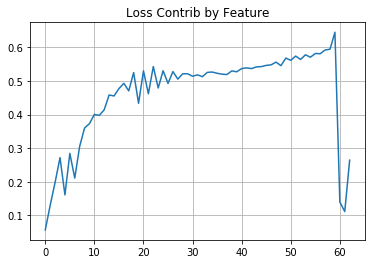

In [216]:
plt.plot(workings['loss_contrib'].sum(axis=(0,1)))
plt.grid(True)
plt.title('Loss Contrib by Feature')
plt.show()

In [30]:
np.sum(workings['loss_contrib'].sum(axis=(0,1)))

28.999979

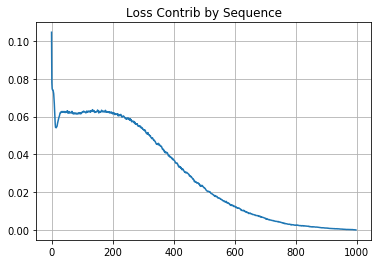

In [31]:
plt.plot(workings['loss_contrib'].sum(axis=(0,2)))
plt.grid(True)
plt.title('Loss Contrib by Sequence')
plt.show()

In [32]:
num_utterances_at_length = [np.sum(workings['target_len'] >= i) for i in range(np.max(workings['target_len']))]
#plt.plot(num_utterances_at_length)

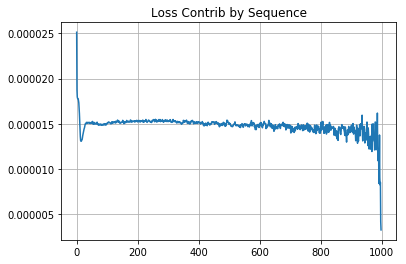

In [33]:
plt.plot(workings['loss_contrib'].sum(axis=(0,2)) 
         / num_utterances_at_length)
plt.grid(True)
plt.title('Loss Contrib by Sequence')
plt.show()

In [34]:
tmp_p = pd.Series(workings['loss_contrib'].sum(axis=(0,2)) / num_utterances_at_length)

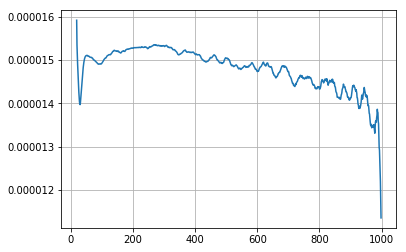

In [35]:
plt.plot(tmp_p.rolling(20).mean())
plt.grid(True)

## Loss by utterance

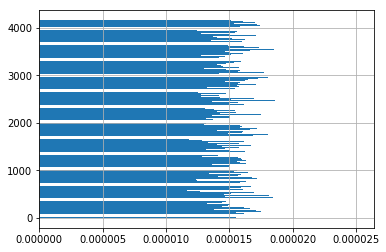

In [36]:
loss_contrib_by_utterance = workings['loss_contrib'].sum(axis=(1,2))
loss_per_unit_length = loss_contrib_by_utterance / workings['target_len']

num_utterance = len(workings['target_len'])
plt.barh(range(num_utterance), loss_per_unit_length)
plt.grid(True)

In [37]:
df = pd.DataFrame(loss_per_unit_length, index=range(num_utterance))

In [38]:
df.sort_values(0, ascending=False).head()

,0
3176,0.000025
918,0.000023
133,0.000021
3065,0.000021
2427,0.000021


In [39]:
df.sort_values(0, ascending=True).head()

,0
540,0.000010
2393,0.000011
3560,0.000011
2728,0.000011
1040,0.000011


### Checks on feature distributions

In [40]:
workings = workings_early

In [41]:
# quick check on mean/variance
tf = workings['target_feat']
op = workings['output']
for idx, t in enumerate(workings['target_len']):
    tf[idx, t:, :] = np.nan
    op[idx, t:, :] = np.nan

Text(0.5,1,u'Mean Feature Values')

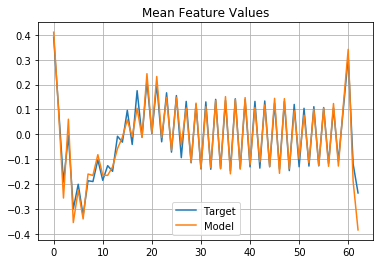

In [42]:
plt.plot(np.nanmean(tf, axis=(0,1)))
plt.plot(np.nanmean(op, axis=(0,1)))
plt.grid(True)
plt.legend(('Target', 'Model'))
plt.title('Mean Feature Values')

Text(0.5,1,u'Std of Feature Values')

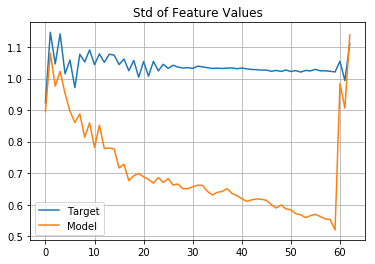

In [43]:
plt.plot(np.nanstd(tf, axis=(0,1)))
plt.plot(np.nanstd(op, axis=(0,1)))
plt.grid(True)
plt.legend(('Target', 'Model'))
plt.title('Std of Feature Values')

In [44]:
#### So VoiceLoop is really struggling to get enough variance in the higher-order mgcs
# Struggling to learn them
# Should we modify the normalisation?
# Or the loss function?
# Or maybe it just doesn't matter?

In [45]:
import scipy.stats as st

In [46]:
# what do the distributions of the features look like? Are they normal?
k = np.zeros(63)
s = np.zeros(63)
v = np.zeros(63)

for i in range(63):
    tmp = tf[:, :, i].flatten()
    tmp[np.isnan(tmp)]
    tmp = np.delete(tmp, np.flatnonzero(np.isnan(tmp)))
    
    v[i] = np.std(tmp)
    s[i] = st.skew(tmp)
    k[i] = st.kurtosis(tmp)

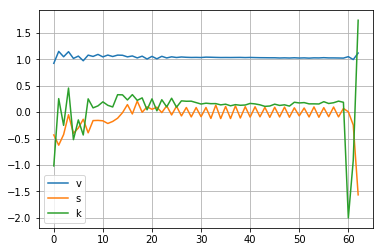

In [47]:
plt.plot(v)
plt.plot(s)
plt.plot(k)
plt.legend(('v', 's', 'k'))
plt.grid(True)
plt.show()

#### Attention

In [48]:
# TODO NEXT: quick look at the attention
plot_attn(attn, txt, NpzFolder(valid_dataset_path).dict)


NameError: name 'attn' is not defined

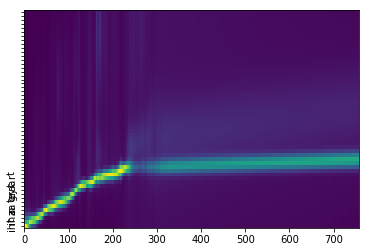

In [49]:
plot_attn(workings['attn'][idx], workings['txt'][idx, :workings['txt_len'][idx]], loader.dataset.dict)

## Loss by Speaker

In [50]:
workings = workings_early

In [51]:
num_spkr = len(np.unique(workings['spkr']))
loss_by_spkr = np.zeros(num_spkr)
loss_by_spkr_norm = np.zeros(num_spkr)

for spkr in np.unique(workings['spkr']):
    idx_this_spkr = np.flatnonzero(workings['spkr'] == spkr)
    loss_by_spkr[spkr] = workings['loss_contrib'][idx_this_spkr, :, :].sum()
    count_by_spkr = workings['target_len'][idx_this_spkr].sum()
    loss_by_spkr_norm[spkr] = loss_by_spkr[spkr] / count_by_spkr

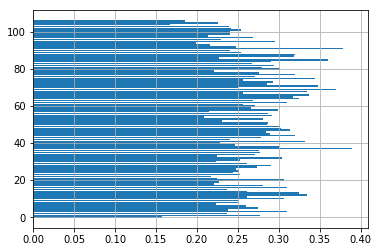

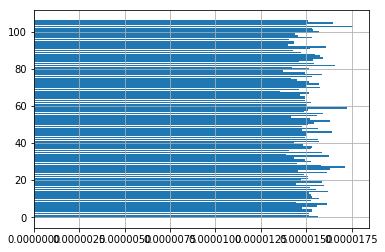

In [52]:
plt.barh(range(num_spkr), loss_by_spkr)
plt.grid(True)
plt.show()

plt.barh(range(num_spkr), loss_by_spkr_norm)
plt.grid(True)
plt.show()

## Checks for a particular utterance

In [226]:
idx = 138 # bad one
#idx = 121 # good one
#idx = 237 # bad one

#idx = 133
#idx = 185
#idx = 365
#idx = 529
#idx = 174
#idx = 181
idx = 55
idx = 201
idx = 4120 # really bad "winning the medal..." getting better by end of 87 epoch
idx = 222
idx = 335  #attention goes wrong towards end "he was pronounced dead in hospital... worth checking out
idx = 336
idx = 337 # mess
idx = 339
idx = 340
idx = 1502 # south african
idx = 1515
idx = 338
idx = 194
idx = 299

In [227]:
#tmp = [n[1][4] for n in npz_map.items()]

In [228]:
#s = [speaker_info[speaker_info.id == t].accents for t in tmp]

In [229]:
#[x=='Indian' for x in s]

In [230]:
npz_map[idx]

(314,
 'data/vctk-16khz-cmu-no-boundaries-all/numpy_features_valid/p326_282.npz',
 86,
 array([20,  4, 35, 36,  2, 39, 12, 31,  6, 27, 27,  7, 34, 20, 12, 28, 12,
        29,  8, 35,  1]),
 326,
 '282')

In [231]:
vctk_raw_folder = '/home/ubuntu/VCTK-Corpus/'
vctk_prebuilt_folder = '/home/ubuntu/vctk-16khz-cmu-no-boundaries/'
speaker_info = get_vtck_speaker_info()

In [232]:
speaker_info[speaker_info.id == npz_map[idx][4]]

,id,age,gender,accents,region
326,326,26,M,Australian,English Sydney


#### Synthesized from Ground Truth Features

In [233]:
generate_merlin_wav(workings['target_feat'][idx, :workings['target_len'][idx], :],
                    '',
                    'tst',
                    '/home/ubuntu/loop/data/vctk-16khz-cmu-no-boundaries-all/norm_info/norm.dat')

Audio('tst' + '.wav', autoplay=True)

{'mgc': 0, 'vuv': 60, 'lf0': 61, 'bap': 62}
complete tst.wav.


#### Synthesized from Output Features

In [234]:
generate_merlin_wav(workings['output'][idx, :, :],
                    '',
                    'tst',
                    '/home/ubuntu/loop/data/vctk-16khz-cmu-no-boundaries-all/norm_info/norm.dat')

Audio('tst' + '.wav', autoplay=True)

{'mgc': 0, 'vuv': 60, 'lf0': 61, 'bap': 62}
complete tst.wav.


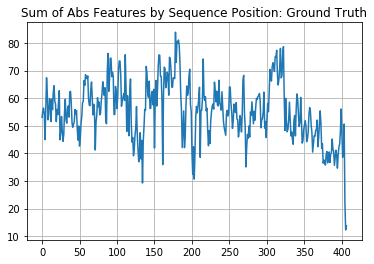

In [320]:
plt.plot(np.abs(workings['target_feat'][idx, :workings['target_len'][idx], :]).sum(1))
plt.grid(True)
plt.title('Sum of Abs Features by Sequence Position: Ground Truth')
plt.show()

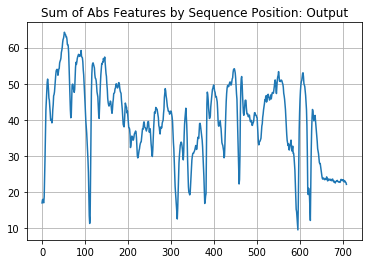

In [70]:
plt.plot(np.abs(workings['output'][idx, :, :]).sum(1))
plt.grid(True)
plt.title('Sum of Abs Features by Sequence Position: Output')
plt.show()

#### Kick out higher-order mgcs...

In [453]:
tmp = copy.deepcopy(workings['output'][idx, :, :])
tmp[:, 20:59] = 0
#tmp[:, 62] = 0
#for i in range(63):
#    tmp[:, i] = tmp[:, i] / np.abs(tmp[:300,i]).mean() * np.abs(workings['target_feat'][idx, :300, i]).mean()
generate_merlin_wav(tmp,
                    '',
                    'tst',
                    '/home/ubuntu/loop/data/vctk/norm_info/norm.dat')

Audio('tst' + '.wav', autoplay=True)

{'mgc': 0, 'vuv': 60, 'lf0': 61, 'bap': 62}
complete tst.wav.


In [287]:
pre_calc_feats = np.load(npz_map[idx][1])

In [290]:
pre_calc_feats['text']

KeyError: 'text is not a file in the archive'

#### Loss Contributions

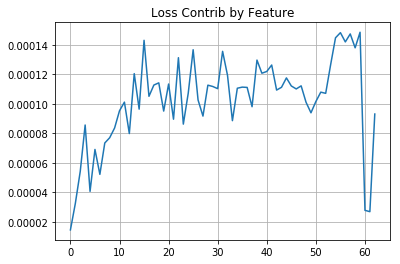

In [322]:
plt.plot(workings['loss_contrib'][idx, :, :].sum(0))
plt.grid(True)
plt.title('Loss Contrib by Feature')
plt.show()

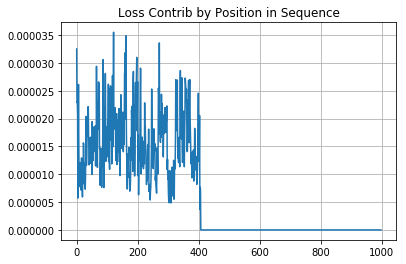

In [323]:
plt.plot(workings['loss_contrib'][idx, :, :].sum(1))
plt.grid(True)
plt.title('Loss Contrib by Position in Sequence')
plt.show()

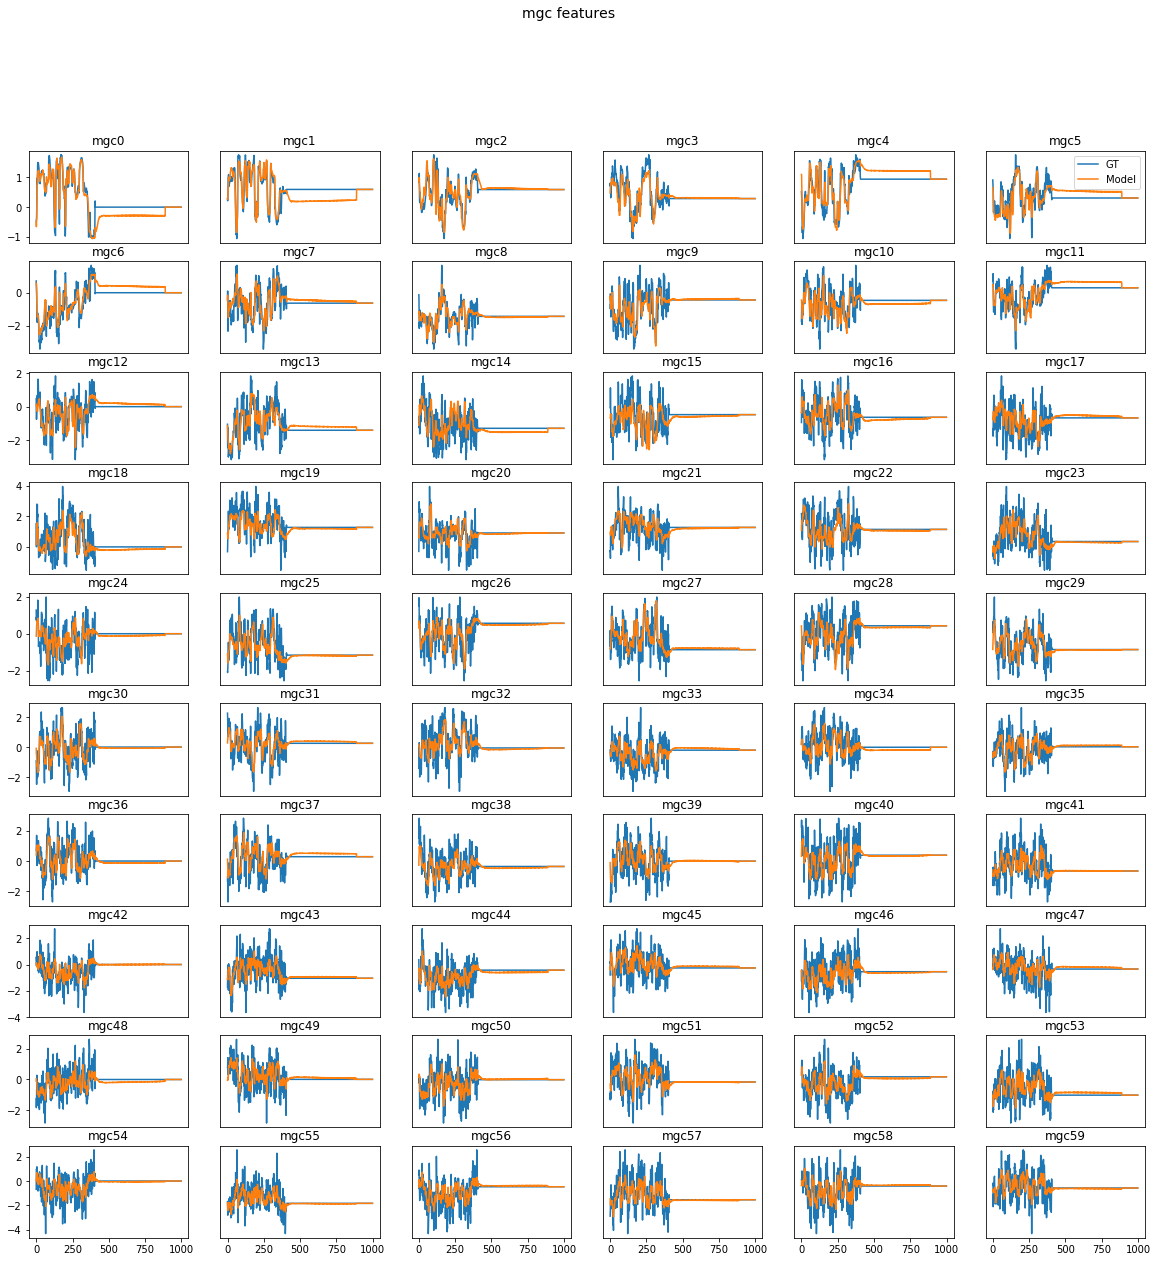

In [324]:
plot_mgc_feature_comparison(workings['target_feat'][idx,:,:], workings['output'][idx,:,:], label_a='GT', label_b='Model')

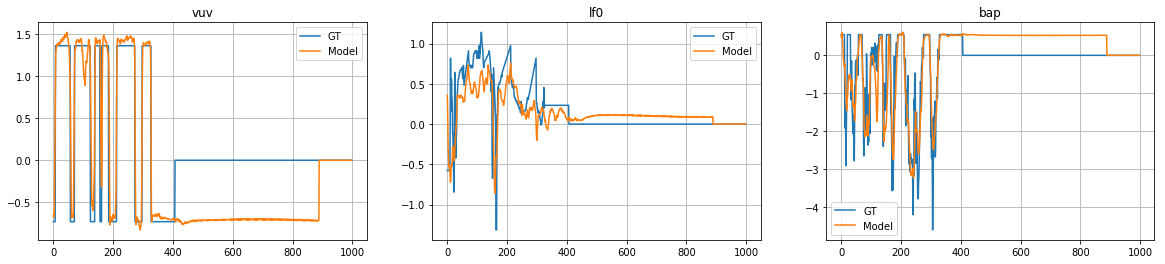

In [325]:
plot_other_feature_comparison(workings['target_feat'][idx,:,:], workings['output'][idx,:,:], label_a='GT', label_b='Model')

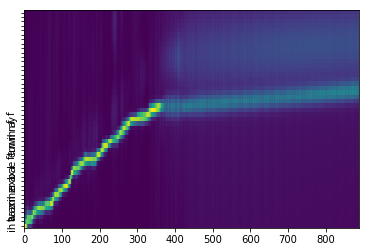

In [326]:
plot_attn(workings['attn'][idx], workings['txt'][idx, :workings['txt_len'][idx]], loader.dataset.dict)

In [112]:
workings = workings_best

# OLD STUFF

In [38]:
workings.keys()

['loss_contrib',
 'spkr',
 'idx_batch',
 'target_len',
 'idx_pos_in_batch',
 'target_feat',
 'txt_len',
 'attn',
 'output',
 'txt']

In [39]:
#workings['spkr'][0]

In [40]:
workings['target_len']

array([767, 713, 574, 516, 730, 536, 530, 530, 408, 493, 602, 433, 414,
       366, 407, 446, 445, 328, 316, 400, 374, 295, 388, 377, 409, 407,
       358, 337, 276, 277, 392, 254, 380, 315, 259, 251, 323, 305, 227,
       416, 311, 269, 280, 334, 310, 321, 225, 261, 212, 198, 254, 215,
       235, 238, 253, 217, 191, 239, 364, 221, 142, 179, 210, 827, 690,
       743, 777, 482, 633, 565, 493, 665, 433, 517, 467, 460, 528, 447,
       390, 510, 420, 448, 450, 496, 375, 344, 318, 364, 380, 349, 305,
       290, 431, 261, 275, 266, 354, 311, 300, 349, 358, 346, 275, 335,
       262, 269, 434, 292, 307, 322, 289, 189, 297, 225, 232, 253, 351,
       367, 369, 201, 247, 179, 191, 135, 153,  93, 767, 791, 723, 485,
       641, 465, 449, 562, 635, 533, 469, 412, 345, 438, 457, 390, 328,
       390, 348, 453, 471, 422, 281, 348, 389, 457, 377, 384, 334, 290,
       284, 303, 296, 386, 251, 324, 260, 412, 344, 380, 232, 289, 241,
       219, 312, 240, 355, 274, 244, 309, 238, 354, 267, 183, 22

In [41]:
workings['target_feat'][1].shape

(979, 63)

In [42]:
loader.dataset.speakers

{'p294': 0,
 'p297': 1,
 'p299': 2,
 'p300': 3,
 'p301': 4,
 'p305': 5,
 'p306': 6,
 'p308': 7,
 'p310': 8,
 'p311': 9,
 'p318': 10,
 'p329': 11,
 'p330': 12,
 'p333': 13,
 'p334': 14,
 'p339': 15,
 'p341': 16,
 'p345': 17,
 'p360': 18,
 'p361': 19,
 'p362': 20}

In [43]:
np.mean([w.sum() for w in workings['loss_contrib']])

0.051919527

In [46]:
w = workings['loss_contrib']

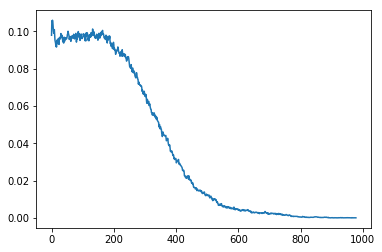

In [47]:
plt.plot(w.sum(axis=(0,2)))

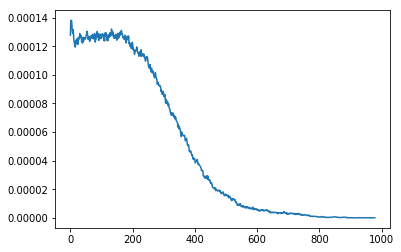

In [48]:
plt.plot(w.sum(axis=(0,2)) / workings['target_len'][0])

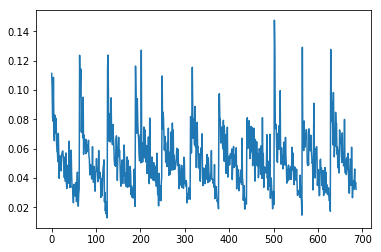

In [49]:
plt.plot(w.sum(axis=(1,2)))

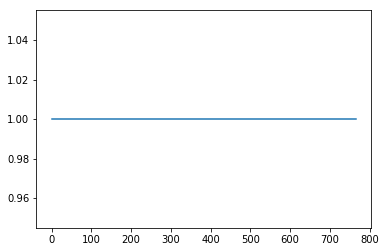

In [50]:
plt.plot([np.sum(workings['target_len'][0] >= i) for i in range(767)])

In [51]:
num_at_len = [np.sum(workings['target_len'][0] >= i) for i in range(767)]

In [52]:
plt.plot(w.sum(axis=(1,2)) / num_at_len)

ValueError: operands could not be broadcast together with shapes (687,) (767,) 

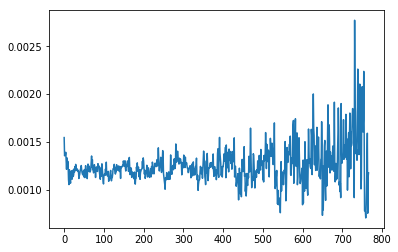

In [233]:
plt.plot(w.sum(axis=(1,2)) / num_at_len)

In [245]:
w = workings['loss_contrib'][2]

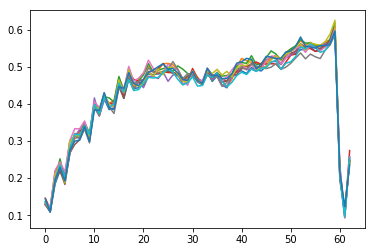

In [247]:
for w in workings['loss_contrib']:
    plt.plot(w.sum(axis=(0,1)))

In [259]:
contrib_by_feat = (np.stack([w.sum(axis=(0,1)) for w in workings['loss_contrib']]).sum(0)/11)

In [261]:
contrib_by_feat.sum()

27.461645

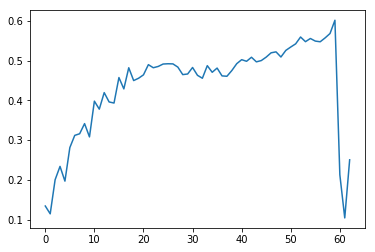

In [273]:
plt.plot(contrib_by_feat)

So it looks like the higher MGC terms have a much bigger contribution to the total loss than vuv, lf0 or bap. Is this okay? Could we get a better result by investigating more carefully?
Make a notebook that allows you to check out the results of a given sample
Therefore need a way to tie each sample in the batch to the original file...

In [140]:
for n in loader.dataset.npzs:
    tmp = loader.dataset.loader(n)
    if tmp == []:
        print 'empty'

In [290]:
attn = workings['attn']

In [293]:
attn[0].shape

(767, 63, 54)

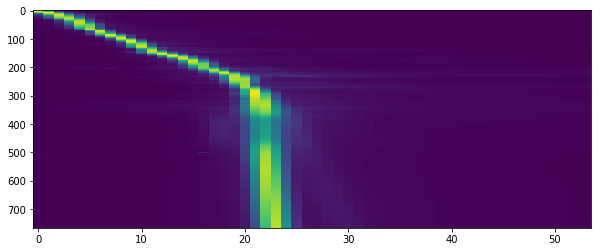

In [308]:
plt.figure(figsize=(10,4))
plt.imshow(attn[0][:, 40, :], aspect='auto')#, origin='lower', interpolation='nearest', cmap=cm.viridis)
#axarr.set_yticks(np.arange(0, len(data.T)))
#axarr.set_yticklabels(labels, rotation=90)

In [4]:
def text2phone(text, char2code):
    seperator = phonemizer.separator.Separator('', '', ' ')
    ph = phonemizer.phonemize(text, separator=seperator)
    ph = ph.split(' ')
    ph.remove('')

    ph = [p.replace('zh', 'jh') for p in ph]

    result = [char2code[p] for p in ph]
    return torch.LongTensor(result)

In [66]:
def trim_pred(out, attn):
    tq = np.abs(attn).sum(1).data

    for stopi in range(1, tq.size(0)):
        col_sum = attn[:stopi, :].abs().sum(0).data.squeeze()

        if type(tq[stopi]) == float:
            if tq[stopi] < 0.5 and col_sum[-1] > 4:
                break
        else:  
            if tq[stopi][0] < 0.5 and col_sum[-1] > 4:
                break

    out = out[:stopi, :]
    attn = attn[:stopi, :]

    return out, attn

In [6]:
def npy_loader_phonemes(path):
    feat = np.load(path)

    txt = feat['phonemes'].astype('int64')
    txt = torch.from_numpy(txt)

    audio = feat['audio_features']
    audio = torch.from_numpy(audio)

    return txt, audio, feat

In [8]:
def generate_sample_with_loop(npz='', text='', spkr_id=1, checkpoint='models/vctk/bestmodel.pth', output_dir = './',
                             npz_path = '/home/ubuntu/loop/data/vctk/numpy_features'):
    #npz = ''
    #text = 'Your tickets for the social issues'
    #text = 'see that girl watch that scene'
    #npz = '/home/ubuntu/loop/data/vctk/numpy_features/p294_011.npz'
    #spkr_id = 12
    #checkpoint = 'checkpoints/vctk/lastmodel.pth'
    #checkpoint = 'models/vctk/bestmodel.pth'
    
    out_dict = dict()
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    gpu = 0

    # load loop weights & params from checkpoint
    weights = torch.load(checkpoint,
                         map_location=lambda storage, loc: storage)
    opt = torch.load(os.path.dirname(checkpoint) + '/args.pth')
    train_args = opt[0]

    train_dataset = NpzFolder('/home/ubuntu/loop/data/vctk/numpy_features')
    char2code = train_dataset.dict
    spkr2code = train_dataset.speakers

    norm_path = train_args.data + '/norm_info/norm.dat'
    norm_path = '/home/ubuntu/loop/data/vctk/norm_info/norm.dat'
    train_args.noise = 0
    
    valid_dataset_path = npz_path + '_valid'

    
    # prepare loop model
    model = Loop(train_args)
    model.load_state_dict(weights)
    if gpu >= 0:
        model.cuda()
    model.eval()

    # check speaker id is valid
    if spkr_id not in range(len(spkr2code)):
        print('ERROR: Unknown speaker id: %d.' % spkr_id)

    # get phone sequence
    txt, feat, spkr, output_fname = None, None, None, None
    if npz is not '':
        # use pre-calculated phonemes etc.
        txt, feat, pre_calc_feat = npy_loader_phonemes(os.path.join(npz_path, npz))

        txt = Variable(txt.unsqueeze(1), volatile=True)
        feat = Variable(feat.unsqueeze(1), volatile=True)
        spkr = Variable(torch.LongTensor([spkr_id]), volatile=True)

        output_file = os.path.basename(npz)[:-4]
        
        out_dict['pre_calc_feat'] = pre_calc_feat
        
    elif text is not '':
        # use specified text string
        # extract phonemes from the text
        txt = text2phone(text, char2code)
        feat = torch.FloatTensor(txt.size(0)*20, 63)
        spkr = torch.LongTensor([spkr_id])

        txt = Variable(txt.unsqueeze(1), volatile=True)
        feat = Variable(feat.unsqueeze(1), volatile=True)
        spkr = Variable(spkr, volatile=True)

        output_file = text.replace(' ', '_')
    else:
        print('ERROR: Must supply npz file path or text as source.')
        raise Exception('Need source')

    # use gpu
    if gpu >= 0:
        txt = txt.cuda()
        feat = feat.cuda()
        spkr = spkr.cuda()

    # run loop model to generate output features 
    loop_feat, attn = model([txt, spkr], feat)
    loop_feat, attn = trim_pred(loop_feat, attn)
    
    # add to output dictionary
    out_dict['txt'] = txt[:,0].squeeze().data.tolist()
    out_dict['spkr'] = spkr
    out_dict['feat'] = feat.data.cpu().numpy()
    out_dict['loop_feat'] = loop_feat.data.cpu().numpy()
    out_dict['attn'] = attn.squeeze().data.cpu().numpy()
    out_dict['output_file'] = output_file
    out_dict['valid_dataset_path'] = valid_dataset_path
    


    # generate .wav file from loop output features
    generate_merlin_wav(loop_feat.data.cpu().numpy(),
                        output_dir,
                        output_file,
                        norm_path)
    
    
    # generate .wav file from original features for reference
    if npz is not '':
        output_orig_fname = os.path.basename(npz)[:-4] + '.orig'
        generate_merlin_wav(feat[:, 0, :].data.cpu().numpy(),
                            output_dir,
                            output_orig_fname,
                            norm_path)
        out_dict['output_orig_fname'] = output_orig_fname
    
    return out_dict

In [9]:
'p294' (140094102801024) = {int} 0
'p297' (140094102801312) = {int} 1
'p299' (140094102801888) = {int} 2
'p300' (140094102872208) = {int} 3
'p301' (140094102800880) = {int} 4
'p305' (140094102801072) = {int} 5
'p306' (140094102874032) = {int} 6
'p308' (140094102801600) = {int} 7
'p310' (140094102801648) = {int} 8
'p311' (140094102801168) = {int} 9
'p318' (140094102802272) = {int} 10
'p329' (140094102801984) = {int} 11
'p330' (140094102801408) = {int} 12
'p333' (140094102872352) = {int} 13
'p334' (140094102802320) = {int} 14
'p339' (140094102802128) = {int} 15
'p341' (140094102872928) = {int} 16
'p345' (140094102801216) = {int} 17
'p360' (140094102872304) = {int} 18
'p361' (140094102874944) = {int} 19
'p362' (140094102872448) = {int} 20

SyntaxError: invalid syntax (<ipython-input-9-34a04edd470b>, line 1)

## Generate Code

In [10]:
loop_dict = generate_sample_with_loop(text='testing testing')

{'mgc': 0, 'vuv': 60, 'lf0': 61, 'bap': 62}
complete testing_testing.wav.


In [11]:
loop_dict = generate_sample_with_loop(npz='p308_254.npz', spkr_id=7)

{'mgc': 0, 'vuv': 60, 'lf0': 61, 'bap': 62}
complete p308_254.wav.
{'mgc': 0, 'vuv': 60, 'lf0': 61, 'bap': 62}
complete p308_254.orig.wav.


In [15]:
Audio(loop_dict['output_file'] + '.wav', autoplay=True)

In [17]:
Audio(loop_dict['output_orig_fname'] + '.wav', autoplay=True)

In [222]:
loop_dict.keys()

['output_orig_fname',
 'spkr',
 'output_file',
 'pre_calc_feat',
 'loop_feat',
 'valid_dataset_path',
 'attn',
 'txt',
 'feat']

In [223]:
for key,val in loop_dict.items():
    exec(key + '=val')

In [224]:
attn.shape
# (n_output_features, n_phones_in_text)

(219, 15)

In [225]:
pre_calc_feat.keys()

['vuv_idx',
 'audio_norminfo',
 'lf0_idx',
 'code2char',
 'text_features',
 'text',
 'durations',
 'audio_features',
 'code2phone',
 'mgc_extent',
 'bap_idx',
 'file_id',
 'phonemes',
 'text_norminfo']

In [226]:
pre_calc_feat['audio_features'].shape

(220, 63)

In [227]:
pre_calc_feat

In [228]:
pre_calc_feat['phonemes'].shape

(15,)

In [229]:
print pre_calc_feat['text']

We are at a crossroads.


In [230]:
print " ".join(pre_calc_feat['code2phone'][pre_calc_feat['phonemes']])

w iy aa r ae t ax k r ao s r ow d z


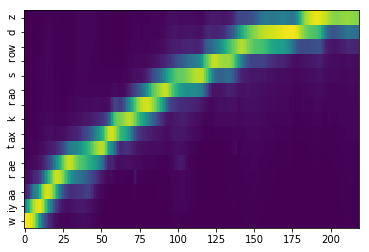

In [231]:
plot_attn(attn, txt, NpzFolder(valid_dataset_path).dict)

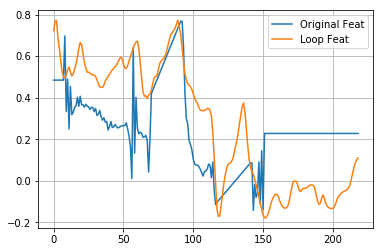

In [238]:
idx_feat = 61
plt.plot(feat[:-idx_end, 0, idx_feat])
plt.plot(loop_feat[:, 0, idx_feat])
plt.grid(True)
plt.legend(('Original Feat', 'Loop Feat'))
plt.show()

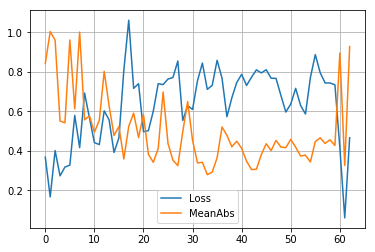

In [239]:
plt.plot(np.square(loop_feat - feat[:-idx_end,:,:]).squeeze().mean(0))
plt.plot(np.mean(np.abs(loop_feat.squeeze()), 0))
plt.grid(True)
plt.legend(('Loss', 'MeanAbs'))

In [240]:
np.square(loop_feat - feat[:-idx_end,:,:]).squeeze().sum() / loop_feat.shape[0]

39.95064569063927

In [241]:
np.mean(np.abs(loop_feat), 0)

array([[ 0.842489  ,  1.00477552,  0.96043956,  0.55105639,  0.54187679,
         0.96183193,  0.61203611,  1.00166619,  0.55707693,  0.57708937,
         0.49464461,  0.55385554,  0.80298418,  0.62669247,  0.47761589,
         0.523597  ,  0.35855764,  0.52438205,  0.59119898,  0.46705166,
         0.58346224,  0.38289273,  0.34179643,  0.41127279,  0.69781584,
         0.43677768,  0.35266012,  0.32480869,  0.49694747,  0.64949894,
         0.45263425,  0.33891329,  0.34184283,  0.27935848,  0.29205516,
         0.36470005,  0.52089405,  0.47847936,  0.42044961,  0.44867203,
         0.41210654,  0.34741107,  0.30521438,  0.30636764,  0.38055992,
         0.43587384,  0.40106311,  0.45270544,  0.41877523,  0.41615254,
         0.45837229,  0.41836566,  0.37391049,  0.37794563,  0.34342614,
         0.44713476,  0.46576571,  0.43746328,  0.45579344,  0.42726162,
         0.8960399 ,  0.32576901,  0.92828971]], dtype=float32)

TODO:
    try smoothing the feature timeseries, see how the output sounds

# Other Investigations

## Loader: Why more files than elements in batch?
1) How to map the batch elements back to the original files?
2) Why are 13 entries getting dropped?

In [78]:
loader = el.get_loader()

In [79]:
len(loader.dataset.npzs)

700

In [80]:
np.hstack(workings['target_len']).shape

(729,)

why are there 687 entries but 700 in the dataset? Turns out that max_seq_len = 1000, so all longer utterances are getting dropped. Also the batches are sorted by decreasing length, so there's no immediately way to link the batch elements back to the original samples.

First: loader.dataset[file_id] has 3 elements:

1) Phoneme code sequence 17

2) WORLD features (ground truth) 232x63

3) Speaker ID (scalar)

In [693]:
loader.dataset[100][2]

11

In [694]:
loader.dataset.npzs[699]

'data/vctk/numpy_features_valid/p311_349.npz'

#### Manually link batch elements back to the original samples

In [61]:
workings['txt'][3][:, 10]

array([16, 19,  9, 18,  9, 16, 18, 41,  7, 11, 31, 34, 29,  7,  2, 34, 18,
       34, 39,  0, 41, 24, 34, 15, 36,  9, 18, 24,  2, 14,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [569]:
d = {b: a for a, b in loader.dataset.dict.iteritems()}

In [74]:
d[workings['txt'][3][:, 10]]


TypeError: unhashable type: 'numpy.ndarray'

In [70]:
workings.keys()

['loss_contrib',
 'spkr',
 'idx_batch',
 'target_len',
 'idx_pos_in_batch',
 'target_feat',
 'txt_len',
 'attn',
 'output',
 'txt']

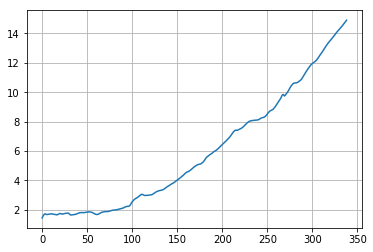

In [339]:
# Modify LF0
hack_feat = copy.deepcopy(out.data.cpu().numpy())
hack_feat[:, 0, 61] += np.square(np.linspace(0,4,hack_feat.shape[0]))
plt.plot(hack_feat[:, 0, 61])
plt.grid(True)

output_file_hack = output_file + '_hack'

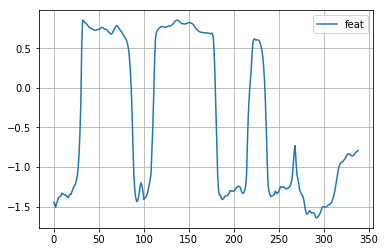

In [303]:
# Visualise VUV
np_feat = feat.data.cpu().numpy()
np_out = out.data.cpu().numpy()
#plt.plot(np_feat[:, 0, 61])
plt.plot(np_out[:, 0, 60])
plt.grid(True)
plt.legend(['feat', 'out'])

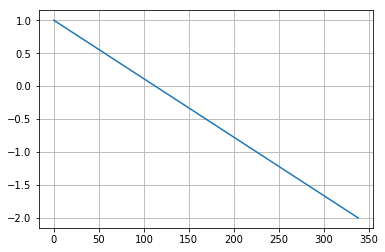

In [304]:
# Modify VUV
hack_feat = copy.deepcopy(out.data.cpu().numpy())
hack_feat[:, 0, 60] = np.linspace(1,-2,hack_feat.shape[0])
plt.plot(hack_feat[:, 0, 60])
plt.grid(True)

output_file_hack = output_file + '_hack'

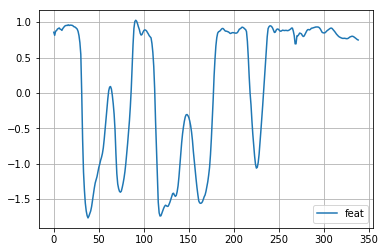

In [179]:
# Visualise BAP
np_feat = feat.data.cpu().numpy()
np_out = out.data.cpu().numpy()
#plt.plot(np_feat[:, 0, 61])
plt.plot(np_out[:, 0, 62])
plt.grid(True)
plt.legend(['feat', 'out'])

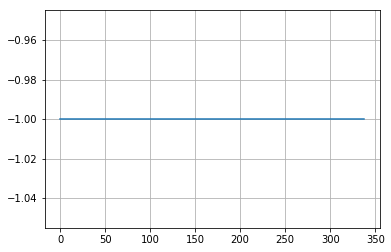

In [186]:
# Modify BAP
hack_feat = copy.deepcopy(out.data.cpu().numpy())
hack_feat[:, 0, 62] = -1# np.linspace(1,-2,hack_feat.shape[0])
plt.plot(hack_feat[:, 0, 62])
plt.grid(True)

output_file_hack = output_file + '_hack'

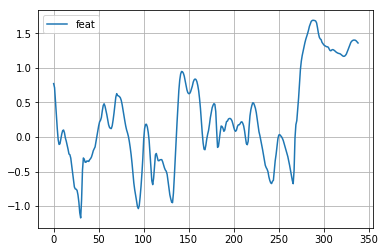

In [277]:
# Visualise MGC0
idx_mgc = 10
np_feat = feat.data.cpu().numpy()
np_out = out.data.cpu().numpy()
plt.plot(np_out[:, 0, idx_mgc])
plt.grid(True)
plt.legend(['feat', 'out'])

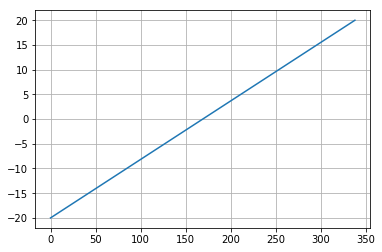

In [278]:
# Modify MGC0
hack_feat = copy.deepcopy(out.data.cpu().numpy())
hack_feat[:, 0, idx_mgc] = np.linspace(-20,+20,hack_feat.shape[0])
plt.plot(hack_feat[:, 0, idx_mgc])
plt.grid(True)

output_file_hack = output_file + '_hack'

#### Generate .wav file from hacked features

In [340]:
generate_merlin_wav(hack_feat[:, 0, :],
                    output_dir,
                    output_file_hack,
                    norm_path)

Audio(output_file_hack + '.wav', autoplay=True)

{'mgc': 0, 'vuv': 60, 'lf0': 61, 'bap': 62}
complete see_that_girl_watch_that_scene_hack.wav.


In [280]:
hack_feat.shape

(339, 1, 63)

In [281]:
# TODO
# .wav file visualisation
# spectrogram?
# use pydub?
# look at normalisation of the features?
# can I get MSE out?

## Spectrograms

In [341]:
import spectrogram as sp

# iPython specific stuff
%matplotlib inline
import IPython.display
from ipywidgets import interact, interactive, fixed

# Packages we're using
from scipy.io import wavfile
from scipy.signal import butter, lfilter
import scipy.ndimage

In [342]:
### Parameters ###
fft_size = 480# 2048 # window size for the FFT
#step_size = int(fft_size/16) # distance to slide along the window (in time)
step_size = 160 # distance to slide along the window (in time)
spec_thresh = 4 # threshold for spectrograms (lower filters out more noise)
lowcut = 500 # Hz # Low cut for our butter bandpass filter
highcut = 7500 #15000 # Hz # High cut for our butter bandpass filter

# For mels
n_mel_freq_components = 40# 64 # number of mel frequency channels
shorten_factor = 1#10 # how much should we compress the x-axis (time)
start_freq = 300 # Hz # What frequency to start sampling our melS from 
end_freq = 8000 # Hz # What frequency to stop sampling our melS from

In [343]:
output_file

'see_that_girl_watch_that_scene'

In [344]:
# This is a nice, clean possum sample
mywav = output_file + '.wav'
mywav_hack = output_file_hack + '.wav'

rate, data = wavfile.read(mywav)
data = sp.butter_bandpass_filter(data, lowcut, highcut, rate, order=1)
#data = butter_bandpass_filter(data, 500, 7500, rate, order=1)
# Only use a short clip for our demo
if np.shape(data)[0]/float(rate) > 10:
    data = data[0:rate*10] 
print('Length in time (s):' + str(np.shape(data)[0]/float(rate)))

rate, data_hack = wavfile.read(mywav_hack)
data_hack = sp.butter_bandpass_filter(data_hack, lowcut, highcut, rate, order=1)

Length in time (s):1.6900625


In [345]:
# Play the audio
IPython.display.Audio(data=data, rate=rate, autoplay=True)

In [346]:
IPython.display.Audio(data=data_hack, rate=rate, autoplay=True)

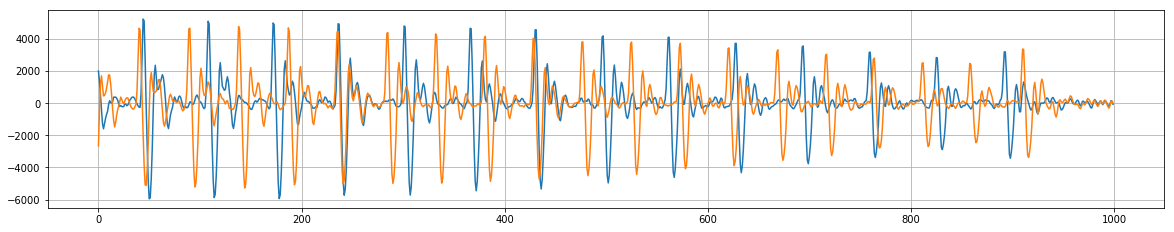

In [347]:
# Plot raw sound data
idx_start = 6000
idx_end = 7000
plt.figure(figsize=[20,8])

plt.subplot(2,1,1)
plt.plot(data[idx_start:idx_end])
#plt.grid()

#plt.subplot(2,1,2)
plt.plot(data_hack[idx_start:idx_end])
plt.grid()

In [348]:
#plt.plot(data_hack - data)

In [349]:
wav_spectrogram = sp.pretty_spectrogram(data.astype('float64'), fft_size = fft_size, 
                                   step_size = step_size, log = True, thresh = spec_thresh)

wav_spectrogram_hack = sp.pretty_spectrogram(data_hack.astype('float64'), fft_size = fft_size, 
                                   step_size = step_size, log = True, thresh = spec_thresh)

Text(0.5,1.05,u'Difference')

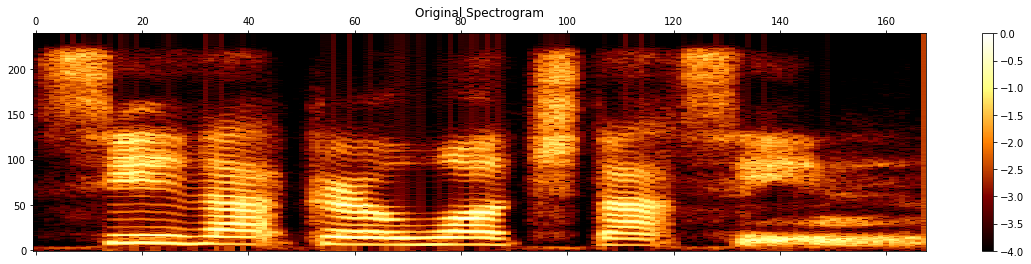

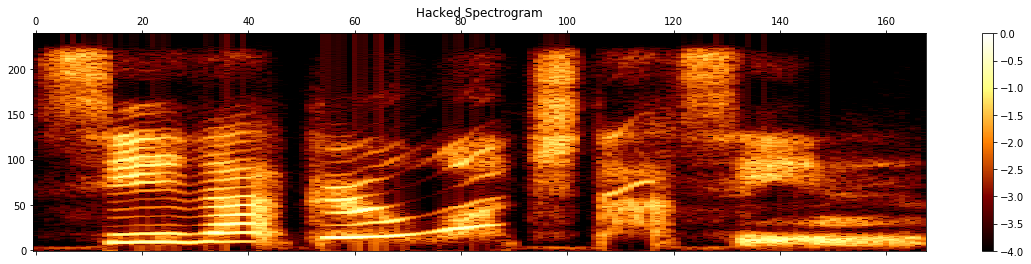

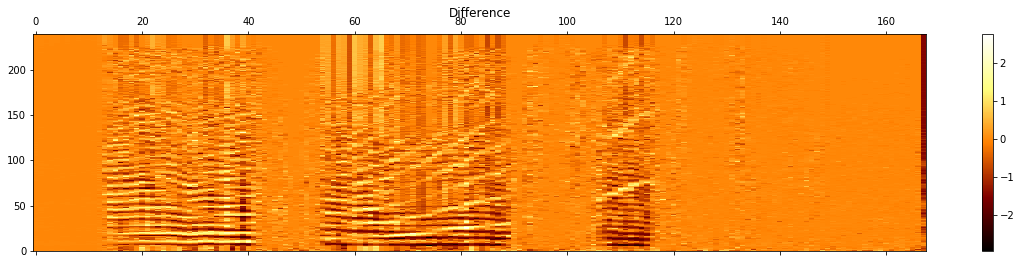

In [350]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))
cax = ax.matshow(np.transpose(wav_spectrogram), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
fig.colorbar(cax)
plt.title('Original Spectrogram')

fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))
cax = ax.matshow(np.transpose(wav_spectrogram_hack), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
fig.colorbar(cax)
plt.title('Hacked Spectrogram')

fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))
cax = ax.matshow(np.transpose(wav_spectrogram_hack - wav_spectrogram), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
fig.colorbar(cax)
plt.title('Difference')

In [336]:
print np.mean(np.square(wav_spectrogram))
print np.mean(np.square(wav_spectrogram_hack - wav_spectrogram))

9.36202110683
0.149842307785


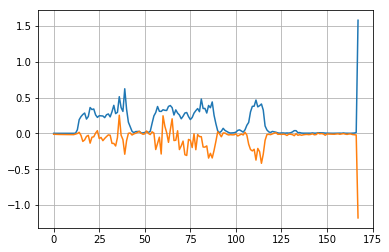

In [338]:
x = wav_spectrogram_hack - wav_spectrogram
plt.plot(np.mean(np.square(x), 1))
plt.grid(True)
plt.plot(np.mean(x, 1))
plt.grid(True)

### Mel Spectrograms

In [294]:
# Generate the mel filters
mel_filter, mel_inversion_filter = sp.create_mel_filter(fft_size = fft_size,
                                                        n_freq_components = n_mel_freq_components,
                                                        start_freq = start_freq,
                                                        end_freq = end_freq, samplerate=16000) # may need to change sample rate

Text(0.5,1.05,u'mel Inversion Filter')

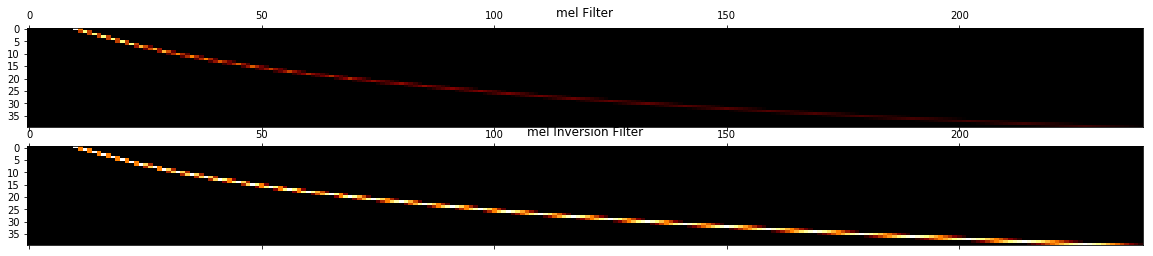

In [295]:
# take a look at both of the filters
fig, ax = plt.subplots(nrows=2,ncols=1, figsize=(20,4))
ax[0].matshow(np.transpose(mel_filter),cmap=plt.cm.afmhot, interpolation='nearest', aspect='auto')
ax[0].set_title('mel Filter')
ax[1].matshow(mel_inversion_filter,cmap=plt.cm.afmhot, interpolation='nearest', aspect='auto')
ax[1].set_title('mel Inversion Filter')

In [296]:
mel_spec = sp.make_mel(wav_spectrogram, mel_filter, shorten_factor = shorten_factor)
mel_spec_hack = sp.make_mel(wav_spectrogram_hack, mel_filter, shorten_factor = shorten_factor)

Text(0.5,1.05,u'Difference')

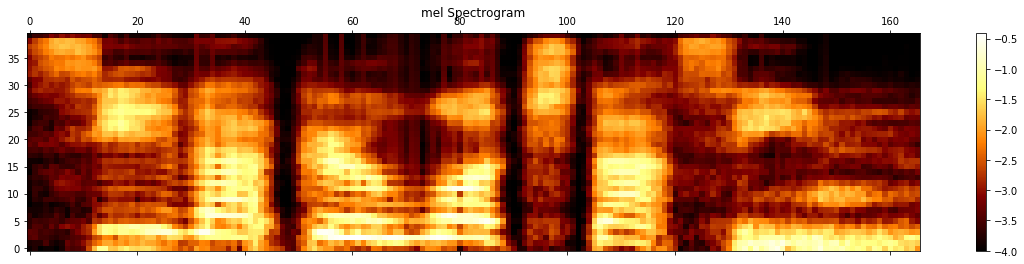

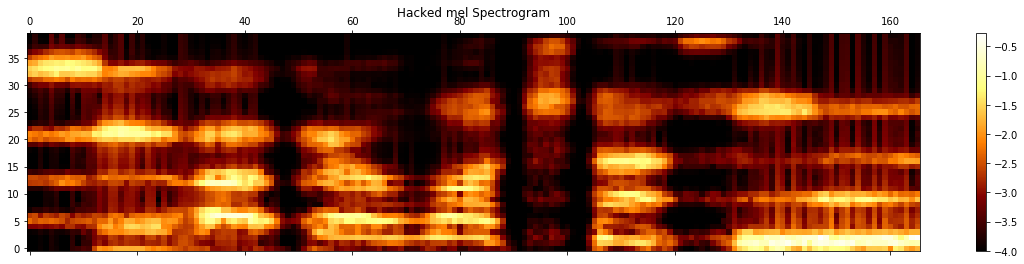

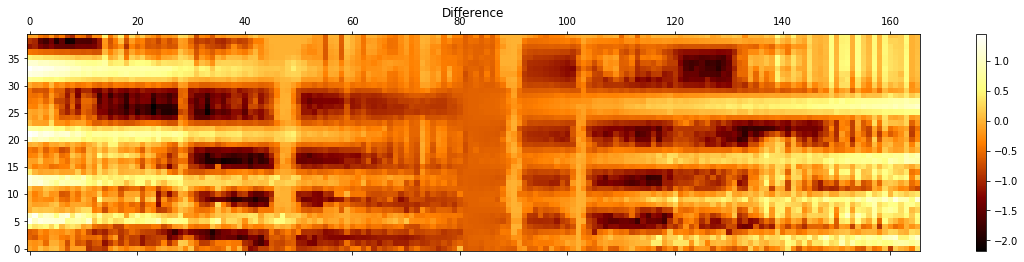

In [297]:
# plot the compressed spec
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))

cax = ax.matshow(np.float64(mel_spec), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
fig.colorbar(cax)
plt.title('mel Spectrogram')

# plot the compressed spec
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))

cax = ax.matshow(np.float64(mel_spec_hack), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
fig.colorbar(cax)
plt.title('Hacked mel Spectrogram')

fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))

cax = ax.matshow(np.float64(mel_spec_hack - mel_spec), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
fig.colorbar(cax)
plt.title('Difference')

In [300]:
print np.mean(np.square(mel_spec))
print np.mean(np.square(mel_spec_hack - mel_spec))

8.1484
0.44263


### Spectrogram Inversion etc.

In [267]:
# Output some stats of our file
print(''.join(['mel Spectrogram Size: ',str(np.shape(mel_spec))]))
print(''.join(['Original Spectrogram Size: ',str(np.shape(np.transpose(wav_spectrogram)))]))
print(''.join(['Original Waveform Size: ',str(np.shape(data))]))
print(''.join(['Length (s): ', str(len(data)/float(rate))]))
print(''.join(['Original Sampling Rate (ms) : ', str(1./float(rate))]))
print(''.join(['New Sampling Rate (ms): ', str(float(np.shape(mel_spec)[1]) / (len(data)/float(rate)))]))

mel Spectrogram Size: (40, 166)
Original Spectrogram Size: (240, 168)
Original Waveform Size: (27041,)
Length (s): 1.6900625
Original Sampling Rate (ms) : 6.25e-05
New Sampling Rate (ms): 98.2212196295


In [268]:
mel_inverted_spectrogram = sp.mel_to_spectrogram(mel_spec, mel_inversion_filter,
                                                spec_thresh=spec_thresh,
                                                shorten_factor=shorten_factor)

Text(0.5,1.05,u'Inverted mel Spectrogram')

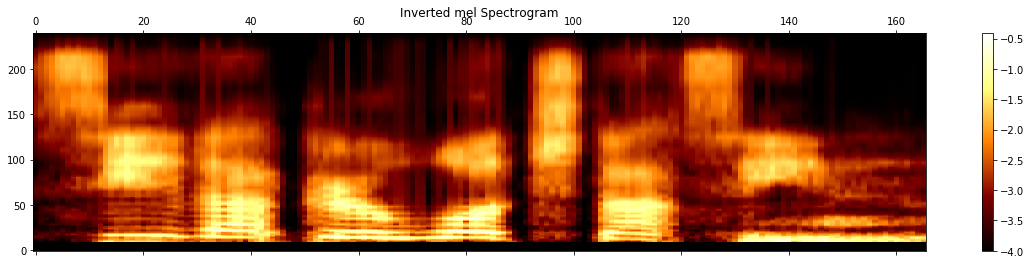

In [269]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))
cax = ax.matshow(np.float64(mel_inverted_spectrogram), cmap=plt.cm.afmhot, origin='lower', aspect='auto',interpolation='nearest')
fig.colorbar(cax)
plt.title('Inverted mel Spectrogram')

In [270]:
inverted_mel_audio = sp.invert_pretty_spectrogram(np.transpose(mel_inverted_spectrogram), fft_size = fft_size,
                                            step_size = step_size, log = True, n_iter = 10)
IPython.display.Audio(data=inverted_mel_audio, rate=rate)

ValueError: operands could not be broadcast together with shapes (166,480) (165,480) 